In [ ]:
# Install these packages if you haven't already!

# pip install pandas
# pip install scikit-learn
# pip install joblib
# pip install numpy
# pip install xgboost
# pip install matplotlib
# pip install seaborn

# __author__    = "Siem Vonk"
# __studentID__ = "i6290798"

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import joblib

import os
print(os.getcwd())

c:\Users\vonks\OneDrive\Documents\! Code\Course 5 ML\MSc_ML_Assignment


## Import new data

In [9]:
# Input new data here:
data_new = pd.read_csv("test_set.csv")

# Keep only the columns in the list in the same order (these had too many missing for training)
with open("columns_to_keep.txt") as f:
    columns_to_keep = [line.strip() for line in f]
data_new = data_new[columns_to_keep]

X_new = data_new.drop(columns=['Viability'])
y_new = data_new['Viability']

# Load trained preprocessing models
imputer = joblib.load("imputer.pkl")
encoder = joblib.load("encoder.pkl")
scaler = joblib.load("scaler.pkl")
feature_order = joblib.load("feature_order.pkl")

# Impute missing values
X_new_imputed = pd.DataFrame(
    imputer.transform(X_new),
    columns=X_new.columns,
    index=X_new.index
)

# Encode categorical variables
categorical_cols = X_new.select_dtypes(include='object').columns
X_new_encoded = pd.DataFrame(
    encoder.transform(X_new_imputed[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_new.index
)

# Combine categorical with numeric features
numeric_cols = X_new_imputed.select_dtypes(include=[np.number]).columns
X_new_final = pd.concat([X_new_imputed[numeric_cols], X_new_encoded], axis=1)

# Align columns to match training
for col in feature_order:
    if col not in X_new_final.columns:
        X_new_final[col] = 0
X_new_final = X_new_final[feature_order]

# Scale features
X_new_scaled = scaler.transform(X_new_final) # Forgetting this line caused me a lot of pain debugging
X_new_scaled_df = pd.DataFrame(X_new_scaled, columns=X_new_final.columns, index=X_new_final.index)

In [16]:
# Load model results (Saved = No are not saved due to low performance and better alternatives)
model_results = pd.read_csv("model_results.csv")
print(model_results)

            Model         MSE  R² Score Saved
0  Ensemble Stack  462.779608  0.560766   Yes
1   Random Forest  470.374591  0.553557   Yes
2    Ensemble AVG  507.077500  0.518722    No
3             KNN  639.341146  0.393188   Yes
4             MLP  648.866790  0.384147   Yes
5         XGBoost  703.059802  0.332711   Yes
6     Elastic Net  784.124789  0.255771    No
7           Lasso  784.124789  0.255771   Yes
8           Ridge  784.614778  0.255305    No
9             SVR  972.709483  0.076781    No


In [25]:
# Random Forest Regression
rf_model = joblib.load("random_forest.pkl")
y_pred_new = rf_model.predict(X_new_scaled_df)
mse = mean_squared_error(y_new, y_pred_new)
r2 = r2_score(y_new, y_pred_new)

print("Random Forest Regression Results")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")


Random Forest Regression Results
Mean Squared Error (MSE): 471.54
R² Score: 0.55


In [ ]:
# Ensemble Stack (RF, KNN, MLP)
stack = joblib.load("stack.pkl")
stack_preds = stack.predict(X_new_scaled_df)
mse_stack = mean_squared_error(y_new, stack_preds)
r2_stack = r2_score(y_new, stack_preds)

print("Stacking Regressor Results")
print(f"MSE: {mse_stack:.2f}")
print(f"R² Score: {r2_stack:.2f}")


Stacking Regressor Results
MSE: 462.46
R² Score: 0.56


In [41]:
# KNN
knn = joblib.load("knn.pkl")
knn_preds = knn.predict(X_new_scaled_df)
mse_knn = mean_squared_error(y_new, knn_preds)
r2_knn = r2_score(y_new, knn_preds)

print("KNN Results")
print(f"MSE: {mse_knn:.2f}")
print(f"R² Score: {r2_knn:.2f}")

KNN Results
MSE: 639.34
R² Score: 0.39


In [27]:
# MLP (Neural Network)
mlp = joblib.load("mlp.pkl")
mlp_preds = mlp.predict(X_new_scaled_df)
mse_mlp = mean_squared_error(y_new, mlp_preds)
r2_mlp = r2_score(y_new, mlp_preds)

print("MLP Results")
print(f"MSE: {mse_mlp:.2f}")
print(f"R² Score: {r2_mlp:.2f}")

MLP Results
MSE: 650.15
R² Score: 0.38


In [28]:
# LASSO (L1 Regularization)
lasso = joblib.load("lasso.pkl")
lasso_preds = lasso.predict(X_new_scaled_df)
mse_lasso = mean_squared_error(y_new, lasso_preds)
r2_lasso = r2_score(y_new, lasso_preds)

print("LASSO Results")
print(f"MSE: {mse_lasso:.2f}")
print(f"R² Score: {r2_lasso:.2f}")

LASSO Results
MSE: 783.39
R² Score: 0.26


## All code from here down was used for training

## Training of the models

In [2]:
data_original = pd.read_csv("data_regression_train_df.csv")
data = data_original.dropna(subset=['Viability']) # 0 missing rows for viability

# Missing values for each variable
missing_values = data.isnull().sum()
print(missing_values)

# Select variables with less than 3000 missing values (around 1/3rd of the samples)
columns_to_keep = missing_values[missing_values < 3000].index
data = data[columns_to_keep]

# Export columns to keep for new data (not included in training so they have to be removed)
columns_to_keep.to_series().to_csv("columns_to_keep.txt", index=False, header=False)

NP_type                  0
Coating               6133
core_size_nm           644
hydro_size_nm         6804
Surf_charge_mV        4779
Surface_area_m2_g     8380
shape                 5511
Dose_microg_mL         165
Duration_h             277
Cell_name                0
Cell_species             0
cell_Organ               0
Cell_morphology         17
Cell_age               596
cell_type               77
sex                   2429
Assay                    0
Test_indicator         195
nanomaterial_group       0
Viability                0
dtype: int64


In [3]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = data.drop(columns=['Viability'])
y = data['Viability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [4]:
# Export test set for testing new data pipeline (should return same results)
test_df = X_test.copy()
test_df['Viability'] = y_test
test_df.to_csv("test_set.csv", index=False) # You can import this at the top to test

In [4]:
# Impute X_train and use the same fitted imputer for X_test
from assignment_functions import assignment_impute
imputer = assignment_impute(max_iter=10)

X_train= imputer.fit_transform(X_train)
X_test = imputer.transform(X_test)

# Save the imputer for new data
joblib.dump(imputer, 'imputer.pkl')

['imputer.pkl']

In [5]:
# Encode categorical variables
from sklearn.preprocessing import OneHotEncoder

# Encode based on training data only
categorical_cols = X_train.select_dtypes(include='object').columns

encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore') # Ignore any unknown categories in new data

X_train_encoded = pd.DataFrame(
    encoder.fit_transform(X_train[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_train.index
)

X_test_encoded = pd.DataFrame(
    encoder.transform(X_test[categorical_cols]),
    columns=encoder.get_feature_names_out(categorical_cols),
    index=X_test.index
)

# Find indices of numeric columns in X_train (same as X_test)
numeric_cols = X_train.select_dtypes(include=[np.number]).columns

# Merge encoded categorical features and the numeric features
X_train_final = pd.concat([X_train[numeric_cols], X_train_encoded], axis=1) # axis = 1 horizontal
X_test_final = pd.concat([X_test[numeric_cols], X_test_encoded], axis=1)

# Save the encoder and feature order
joblib.dump(encoder, 'encoder.pkl')
joblib.dump(X_train_final.columns.tolist(), 'feature_order.pkl')


['feature_order.pkl']

In [6]:
# Scaling X_train and X_test 

from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() # Mean=0, std=1
X_train_scaled = scaler.fit_transform(X_train_final)
X_test_scaled = scaler.transform(X_test_final)
joblib.dump(scaler, 'scaler.pkl') # Save the scaler for new data

# Convert back to dataframes with column names and index preserved
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train_final.columns, index=X_train_final.index)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test_final.columns, index=X_test_final.index)



In [ ]:
# Lasso (took around 3 seconds)
from sklearn.linear_model import LassoCV

param_grid_lasso = {
    'alpha': [0.01, 0.1, 0.5, 1, 10, 100, 1000]
}

# Lasso regression with cross-validation kfold 5
lasso_cv = LassoCV(alphas=param_grid_lasso['alpha'], cv=5, random_state=1, max_iter=5000)
lasso_cv.fit(X_train_scaled_df, y_train)

y_pred_lasso = lasso_cv.predict(X_test_scaled_df)

lasso_best = lasso_cv.alpha_
mse_lasso = mean_squared_error(y_test, y_pred_lasso)
r2_lasso = r2_score(y_test, y_pred_lasso)

print("Lasso Regression Results")
print(f"Mean Squared Error (MSE): {mse_lasso:.2f}")
print(f"R² Score: {r2_lasso:.2f}")
print(f"Best Lasso alpha: {lasso_best}")

Betas_Lasso = pd.Series(lasso_cv.coef_, index=X_train_scaled_df.columns)
Betas_Lasso = Betas_Lasso.abs().sort_values(ascending=False)
Betas_Lasso.head(5)

# Save the model
joblib.dump(lasso_cv, 'lasso.pkl')

Lasso Regression Results
Mean Squared Error (MSE): 783.39
R² Score: 0.26
Best Lasso alpha: 0.1


['lasso.pkl']

In [29]:
# Ridge (took around 3 seconds)
from sklearn.linear_model import RidgeCV

param_grid_ridge = {
    'alpha': [0.01, 0.1, 0.5, 1, 10, 100, 1000]
}

# Ridge regression with 5-fold CV
ridge_cv = RidgeCV(alphas=param_grid_ridge['alpha'], cv=5)
ridge_cv.fit(X_train_scaled_df, y_train)

y_pred_ridge = ridge_cv.predict(X_test_scaled_df)

ridge_best = ridge_cv.alpha_
mse_ridge = mean_squared_error(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

print("Ridge Regression Results")
print(f"Mean Squared Error (MSE): {mse_ridge:.2f}")
print(f"R² Score: {r2_ridge:.2f}")
print(f"Best Ridge alpha: {ridge_best}")

Betas_Ridge = pd.Series(ridge_cv.coef_, index=X_train_scaled_df.columns)
Betas_Ridge = Betas_Ridge.abs().sort_values(ascending=False)
Betas_Ridge.head(5)


# Around the same as lasso


Ridge Regression Results
Mean Squared Error (MSE): 784.21
R² Score: 0.26
Best Ridge alpha: 1000.0


NP_type_Ag            3.704867
NP_type_Dendrimer     3.528715
NP_type_EudragitRL    3.359812
NP_type_CdTe          3.008252
Assay_MTS             2.792514
dtype: float64

In [10]:
# Elastic Net (took around 2 minutes)
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import ElasticNet

EN = ElasticNet(random_state=1, max_iter=5000)
param_grid_EN = {
    'alpha': [0.01, 0.1, 0.5, 1, 10, 100],
    'l1_ratio': [0.1, 0.3, 0.6, 0.9, 1.0]  # Lasso (l1_ratio=1) to Ridge (=0)
}

# EN regression with cross-validation kfold 5
EN_cv = GridSearchCV(EN, param_grid_EN, cv=5, scoring='neg_mean_squared_error')
EN_cv.fit(X_train_scaled_df, y_train)

y_pred_EN = EN_cv.predict(X_test_scaled_df)

In [11]:
# EN results

mse_EN = mean_squared_error(y_test, y_pred_EN)
r2_EN = r2_score(y_test, y_pred_EN)

best_params_EN = EN_cv.best_params_
best_alpha_EN = best_params_EN['alpha']
best_l1_ratio_EN = best_params_EN['l1_ratio']

print(f"Mean Squared Error (MSE): {mse_EN:.2f}")
print(f"R² Score = {r2_EN:.2f}")
print(f"Best alpha: {best_alpha_EN} and l1_ratio: {best_l1_ratio_EN}")

# Get the best ElasticNet model from GridSearchCV
best_en_model = EN_cv.best_estimator_

Betas_EN = pd.Series(best_en_model.coef_, index=X_train_scaled_df.columns)
Betas_EN.head(5)

# Lasso seems to perform better and is a lot faster so EN is not saved


Mean Squared Error (MSE): 784.12
R² Score = 0.26
Best alpha: 0.1 and l1_ratio: 1.0


core_size_nm      0.697225
Dose_microg_mL   -2.859275
Duration_h       -3.160244
NP_type_Ag       -4.915592
NP_type_Al2O3     0.403925
dtype: float64

In [21]:
# Random Forest (took around 3 seconds)

from sklearn.ensemble import RandomForestRegressor

# Using default (MSE) criterion for regression
rf = RandomForestRegressor(
    n_estimators=100,
    random_state=123,
    n_jobs=-1
)

rf.fit(X_train_scaled_df, y_train)
y_pred_rf_old = rf.predict(X_test_scaled_df)
#joblib.dump(rf, 'random_forest.pkl')

mse_rf_old = mean_squared_error(y_test, y_pred_rf_old)
r2_rf_old = r2_score(y_test, y_pred_rf_old)

print(f"Random Forest Regression Results")
print(f"Mean Squared Error (MSE): {mse_rf_old:.4f}")
print(f"R^2 Score: {r2_rf_old:.4f}")


Random Forest Regression Results
Mean Squared Error (MSE): 471.5396
R^2 Score: 0.5525


In [22]:
# Random Forest Regression: slight improvement with some tuning
from sklearn.ensemble import RandomForestRegressor

# Using default (MSE) criterion for regression
rf = RandomForestRegressor(
    n_estimators=100,
    min_samples_split=10,  # Prevents the tree from splitting too early
    min_samples_leaf=4,  # Prevents overly granular leaf nodes
    random_state=123,
    n_jobs=-1
)

rf.fit(X_train_scaled_df, y_train)
y_pred_rf = rf.predict(X_test_scaled_df)
joblib.dump(rf, 'random_forest.pkl')

mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest Regression Results")
print(f"Mean Squared Error (MSE): {mse_rf:.4f}")
print(f"R^2 Score: {r2_rf:.4f}")

Random Forest Regression Results
Mean Squared Error (MSE): 464.4398
R^2 Score: 0.5592


In [ ]:
# xgboost 
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score

xgb_model = XGBRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=1)
xgb_model.fit(X_train_scaled_df, y_train)

y_pred_xgb = xgb_model.predict(X_test_scaled_df)
joblib.dump(xgb_model, 'xgb.pkl')

mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print("XGBoost Regression Results:")
print(f"Mean Squared Error (MSE): {mse_xgb:.4f}")
print(f"R² Score: {r2_xgb:.4f}")

# Worse than random forest but better than lasso and EN (R2 of 0.33)


XGBoost Regression Results:
Mean Squared Error (MSE): 702.6405
R² Score: 0.3331


In [ ]:
from sklearn.svm import SVR

# SVR model (RBF kernel is default)
svr = SVR(C=1.0, epsilon=0.1)
svr.fit(X_train_scaled_df, y_train)

y_pred_svr = svr.predict(X_test_scaled_df)

mse_svr = mean_squared_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print("\nSVR Regression Results:")
print(f"Mean Squared Error (MSE): {mse_svr:.4f}")
print(f"R² Score: {r2_svr:.4f}")

# very low R2 score (0.08) so not saved



SVR Regression Results:
Mean Squared Error (MSE): 972.7095
R² Score: 0.0768


In [29]:
# KNN regression (almost instant)

from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_scaled_df, y_train)

y_pred_knn = knn.predict(X_test_scaled_df)
mse_knn = mean_squared_error(y_test, y_pred_knn)
r2_knn = r2_score(y_test, y_pred_knn)

print("KNN Regression Results")
print(f"Mean Squared Error (MSE): {mse_knn:.2f}")
print(f"R² Score: {r2_knn:.2f}")

# Decent R2 score (0.39)
joblib.dump(knn, 'knn.pkl')


KNN Regression Results
Mean Squared Error (MSE): 640.59
R² Score: 0.39


['knn.pkl']

In [30]:
# Neural Network (MLP) regression (took around 1 minute)
from sklearn.neural_network import MLPRegressor

# Multi-layer Perceptron regressor with one hidden layer of 100 neurons, ReLU activation
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=1000, random_state=123)
mlp.fit(X_train_scaled_df, y_train)

# Predict
y_pred_mlp = mlp.predict(X_test_scaled_df)

In [31]:
# Neural Networks Evaluation
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("Neural Network Regression Results")
print(f"Mean Squared Error (MSE): {mse_mlp:.2f}")
print(f"R² Score: {r2_mlp:.2f}")

# Decent R2 score (0.39)
joblib.dump(mlp, 'mlp.pkl')

Neural Network Regression Results
Mean Squared Error (MSE): 640.09
R² Score: 0.39


['mlp.pkl']

In [ ]:
# Overview of all models
results = pd.DataFrame({
    'Model': ['Lasso', 'Ridge', 'Elastic Net', 'Random Forest', 'XGBoost', 'SVR', 'KNN', 'MLP'],
    'MSE': [mse_lasso, mse_ridge, mse_EN, mse_rf, mse_xgb, mse_svr, mse_knn, mse_mlp],
    'R² Score': [r2_lasso, r2_ridge, r2_EN, r2_rf, r2_xgb, r2_svr, r2_knn, r2_mlp]
})
results = results.sort_values(by='R² Score', ascending=False)
print(results)

NameError: name 'mse_lasso' is not defined

In [33]:
# Ensemble (Averaging) of Random Forest, KNN, and MLP
preds_rf = rf.predict(X_test_scaled_df)
preds_knn = knn.predict(X_test_scaled_df)
preds_mlp = mlp.predict(X_test_scaled_df)

# Simple average (unweighted)
ensemble_preds = (preds_rf + preds_knn + preds_mlp) / 3

# Evaluation
mse_ensemble = mean_squared_error(y_test, ensemble_preds)
r2_ensemble = r2_score(y_test, ensemble_preds)

print("Ensemble (Averaging) Results")
print(f"MSE: {mse_ensemble:.2f}")
print(f"R² Score: {r2_ensemble:.2f}")

# R2 of 0.52 which is lower than RF


Ensemble (Averaging) Results
MSE: 508.82
R² Score: 0.52


In [34]:
# Ensemble with stacking (took around 2.5 minutes)
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression

estimators = [
    ('rf', rf),
    ('knn', knn),
    ('mlp', mlp),
]

# Define meta-learner
stack = StackingRegressor(
    estimators=estimators,
    final_estimator=LinearRegression(),
    cv=5,
    n_jobs=-1
)

stack.fit(X_train_scaled_df, y_train)

# Predict and evaluate
stack_preds = stack.predict(X_test_scaled_df)
mse_stack = mean_squared_error(y_test, stack_preds)
r2_stack = r2_score(y_test, stack_preds)

print("Stacking Regressor Results")
print(f"MSE: {mse_stack:.2f}")
print(f"R² Score: {r2_stack:.2f}")

# R2 score of 0.56 (best one so far)
joblib.dump(stack, 'stack.pkl')

Stacking Regressor Results
MSE: 459.38
R² Score: 0.56


['stack.pkl']

In [39]:
# Overview of all models (now including ensembles)
results = pd.DataFrame({
    'Model': ['Lasso', 'Ridge', 'Elastic Net', 'Random Forest', 'XGBoost', 'SVR', 'KNN', 'MLP', 'Ensemble AVG', 'Ensemble Stack'],
    'MSE': [mse_lasso, mse_ridge, mse_EN, mse_rf, mse_xgb, mse_svr, mse_knn, mse_mlp, mse_ensemble, mse_stack],
    'R² Score': [r2_lasso, r2_ridge, r2_EN, r2_rf, r2_xgb, r2_svr, r2_knn, r2_mlp, r2_ensemble, r2_stack],
    'Saved': ['Yes', 'No', 'No', 'Yes', 'Yes', 'No', 'Yes', 'Yes', 'No', 'Yes']
})

results = results.sort_values(by='R² Score', ascending=False)
results.to_csv("model_results.csv", index=False)
print(results)

            Model         MSE  R² Score Saved
9  Ensemble Stack  462.779608  0.560766   Yes
3   Random Forest  470.374591  0.553557   Yes
8    Ensemble AVG  507.077500  0.518722    No
6             KNN  639.341146  0.393188   Yes
7             MLP  648.866790  0.384147   Yes
4         XGBoost  703.059802  0.332711   Yes
2     Elastic Net  784.124789  0.255771    No
0           Lasso  784.124789  0.255771   Yes
1           Ridge  784.614778  0.255305    No
5             SVR  972.709483  0.076781    No


## Figures

In [7]:
## Y_test line and y_pred line with samples on x axis
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

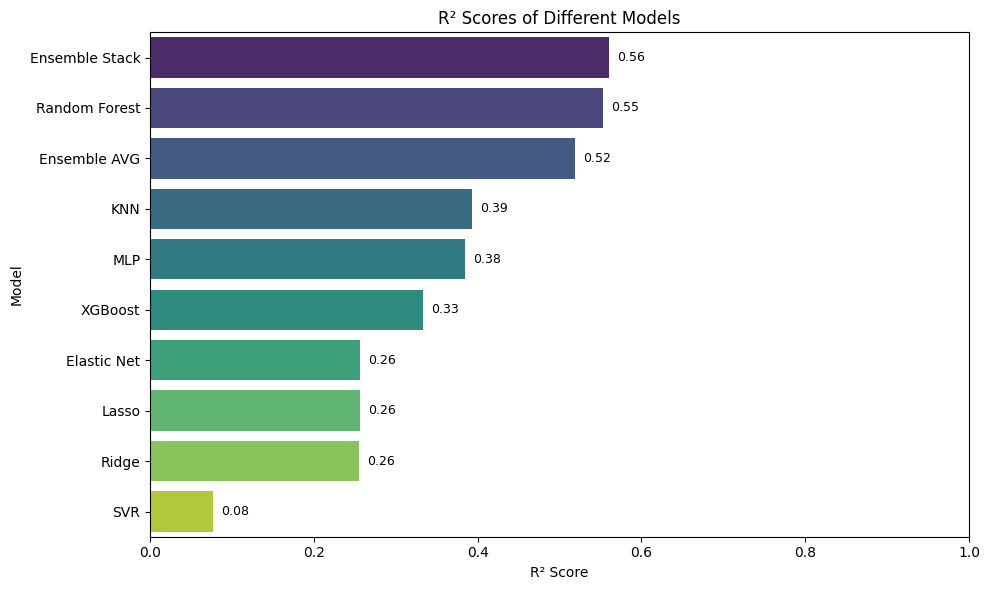

In [4]:
# Bar chart of R² scores

plt.figure(figsize=(10, 6))
ax = sns.barplot(
    x='R² Score',
    y='Model',
    data=results,
    hue='Model',
    palette='viridis',
    legend=False
)

# Add R² value labels on each bar
for container in ax.containers:
    for bar in container:
        width = bar.get_width()
        y_pos = bar.get_y() + bar.get_height() / 2
        ax.text(width + 0.01, y_pos, f"{width:.2f}", va='center', ha='left', fontsize=9)

#plt.axvline(x=0.5, color='red', linestyle='--', label='R² = 0.5')
plt.title('R² Scores of Different Models')
plt.xlabel('R² Score')
plt.xlim(0,1)
plt.tight_layout()
plt.show()


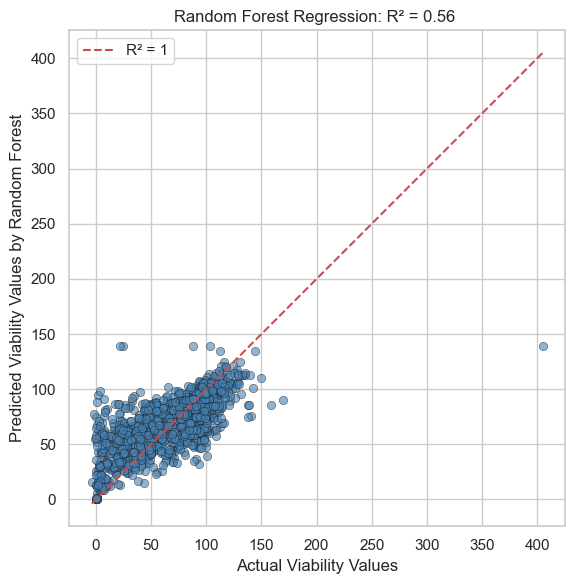

In [27]:
# y_test vs y_pred_rf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf, color="steelblue", alpha=0.6, edgecolor='k')

# Plot y = x line for reference
max_val = max(max(y_test), max(y_pred_rf))
min_val = min(min(y_test), min(y_pred_rf))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='R² = 1')

# Labels and title
plt.xlabel("Actual Viability Values")
plt.ylabel("Predicted Viability Values by Random Forest")
plt.title(f"Random Forest Regression: R² = {r2_rf:.2f} ")
plt.legend()
# Set 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


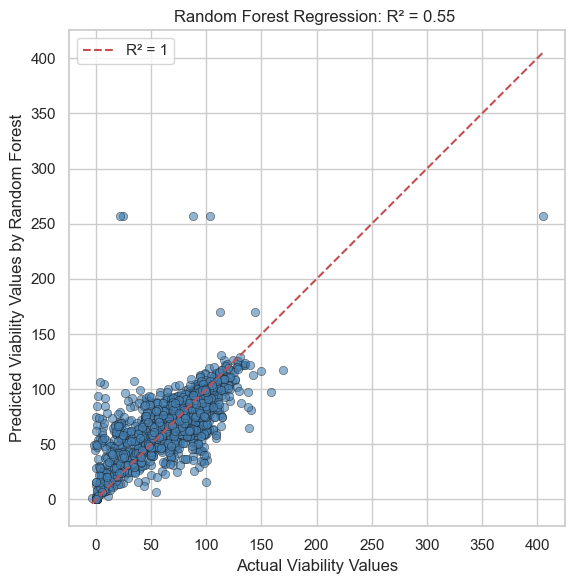

In [28]:
# The new RF seems to have less wrong predictions and removed the incorrect ones at 250

# Plot the old RF (without tuning) vs y_test
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred_rf_old, color="steelblue", alpha=0.6, edgecolor='k')

# Plot y = x line for reference
max_val = max(max(y_test), max(y_pred_rf_old))
min_val = min(min(y_test), min(y_pred_rf_old))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='R² = 1')

# Labels and title
plt.xlabel("Actual Viability Values")
plt.ylabel("Predicted Viability Values by Random Forest")
plt.title(f"Random Forest Regression: R² = {r2_rf_old:.2f} ")
plt.legend()
# Set 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()


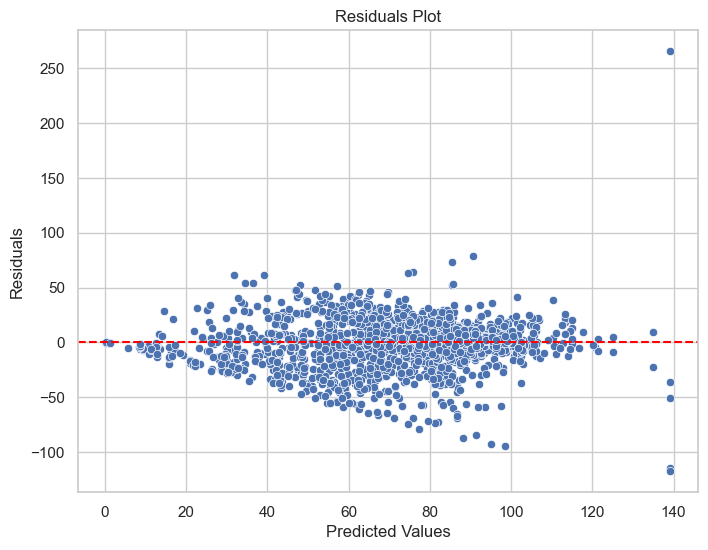

In [ ]:
# Residuals plot for Random Forest (new model)

residuals = y_test - y_pred_rf
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred_rf, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals Plot')
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.show()


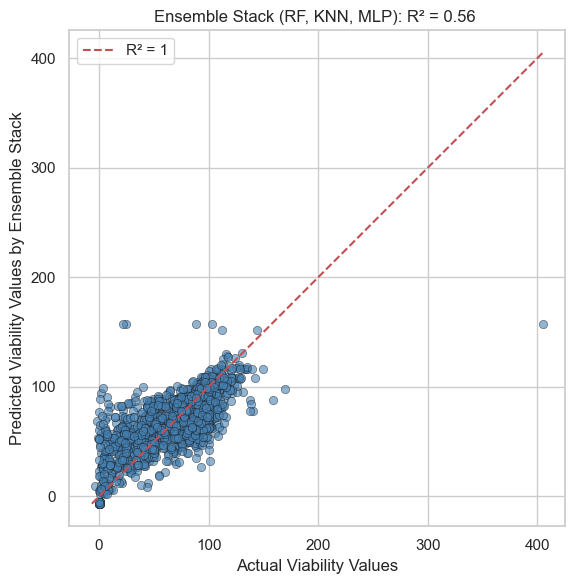

In [35]:
# Plot the stack predictions vs y_test
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Create scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=stack_preds, color="steelblue", alpha=0.6, edgecolor='k')

# Plot y = x line for reference
max_val = max(max(y_test), max(stack_preds))
min_val = min(min(y_test), min(stack_preds))
plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='R² = 1')

# Labels and title
plt.xlabel("Actual Viability Values")
plt.ylabel("Predicted Viability Values by Ensemble Stack")
plt.title(f"Ensemble Stack (RF, KNN, MLP): R² = {r2_stack:.2f} ")
plt.legend()
# Set 1:1 aspect ratio
plt.gca().set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()
